In [1]:
from waveletvar import *
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
exchange = ccxt.binance()
btc_symbol = 'BTC/USDT'
sol_symbol = 'SOL/USDT'
end_date = datetime.now()
start_date = end_date - timedelta(days=720)


btc_ohlcv = exchange.fetch_ohlcv(btc_symbol, timeframe='1d', since=int(start_date.timestamp() * 1000), limit=720)
btc_df = pd.DataFrame(btc_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'], unit='ms', utc=True)  # Ensure UTC
btc_df.set_index('timestamp', inplace=True)

sol_ohlcv = exchange.fetch_ohlcv(sol_symbol, timeframe='1d', since=int(start_date.timestamp() * 1000), limit=720)
sol_df = pd.DataFrame(sol_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
sol_df['timestamp'] = pd.to_datetime(sol_df['timestamp'], unit='ms', utc=True)  # Ensure UTC
sol_df.set_index('timestamp', inplace=True)




In [3]:

btc_data_log = np.log(btc_df[['close']].rename(columns={'close': 'BTC'}))
sol_data_log = np.log(sol_df[['close']].rename(columns={'close': 'sol'}))

combined_data = pd.merge(btc_data_log, sol_data_log, left_index=True, right_index=True, how='inner')

# Convert to NumPy arrays
btc_logr = np.diff(combined_data['BTC'].to_numpy())
sol_logr = np.diff(combined_data['sol'].to_numpy())


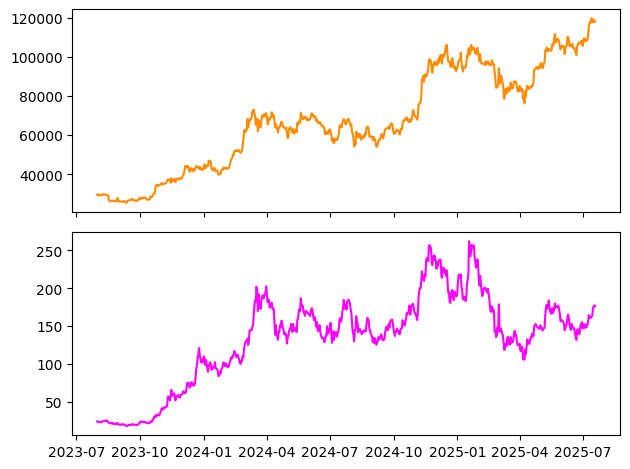

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(btc_df["close"],  color='darkorange')
ax[1].plot(sol_df["close"], color='magenta')

plt.tight_layout()  # Optional: improves spacing between plots
plt.show()


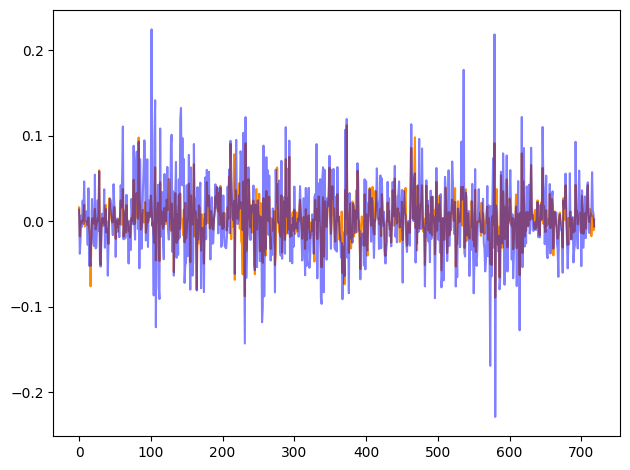

In [5]:
figur = plt.figure()

plt.plot(btc_logr, color="darkorange", alpha = 1)
plt.plot(sol_logr, color="blue", alpha = 0.5)
plt.tight_layout()
plt.show()



In [6]:
wavelet_correlation_CI(btc_logr, sol_logr, "db6", 1, 0, 0.05)

[0.7261586215247893, 0.7592190711569372, 0.788776588061069]

In [7]:
lags = [i for i in range(-100, 101)]
levels = [i for i in range(1,7)]
P1, P2 = np.meshgrid(levels, lags)
Z = np.array([[wavelet_correlation(btc_logr, sol_logr, "db6", P1, P2) for P1 in levels] for P2 in lags])

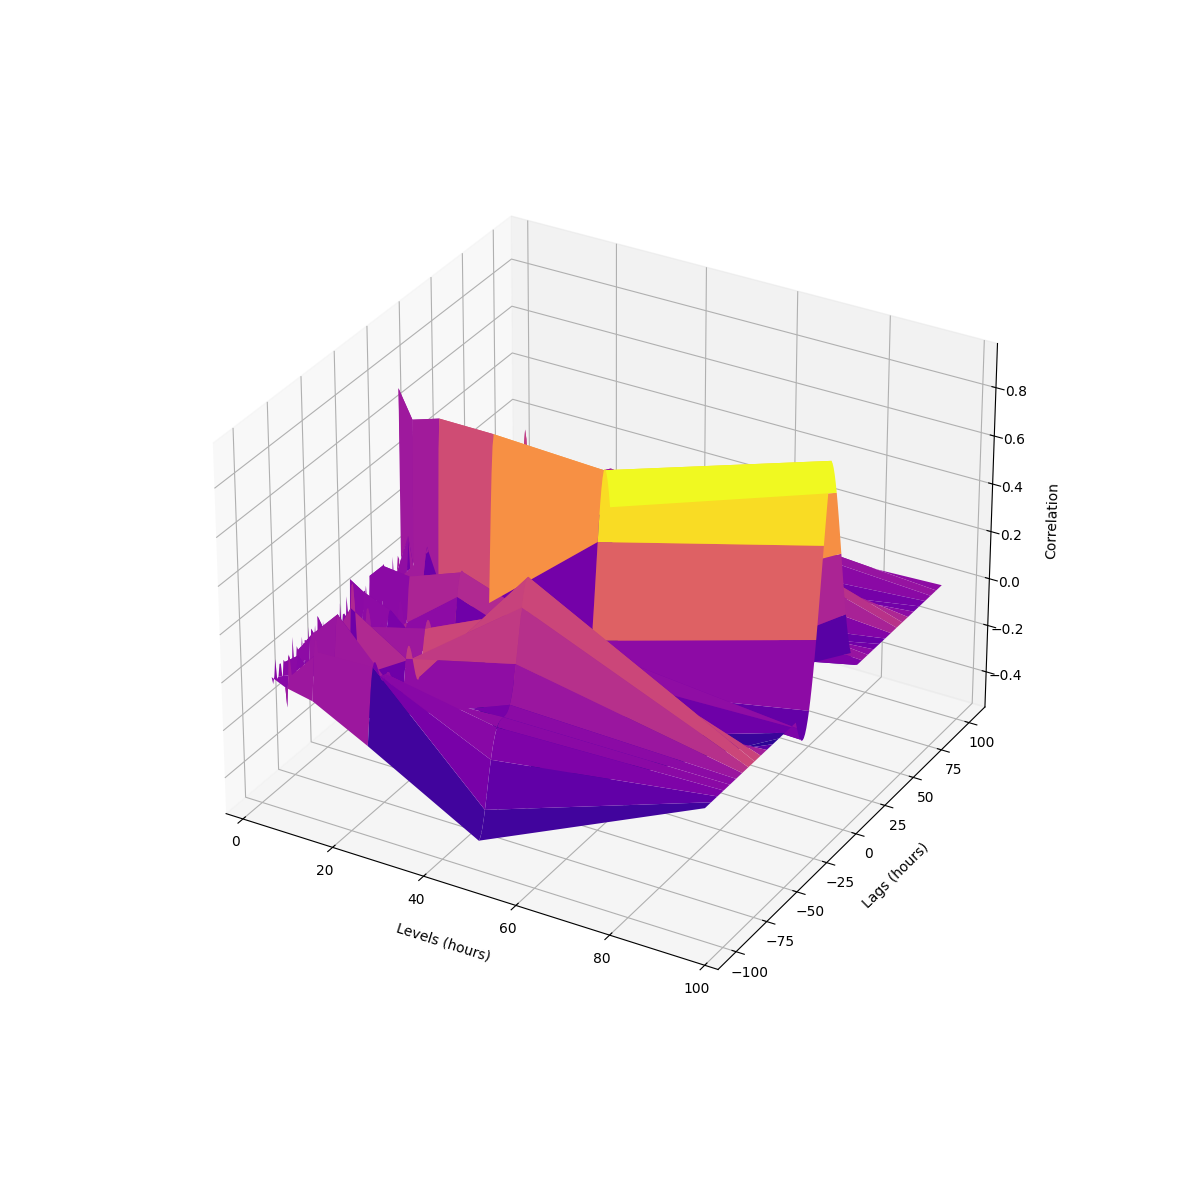

In [8]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(1.5*2**(P1), P2, Z, cmap='plasma')
ax.set_xlabel('Levels (hours)', labelpad=15)
ax.set_ylabel('Lags (hours)', labelpad=15)
ax.set_zlabel('Correlation',labelpad=15)
ax.set_box_aspect(None, zoom=0.75) 
plt.tight_layout()
plt.show()

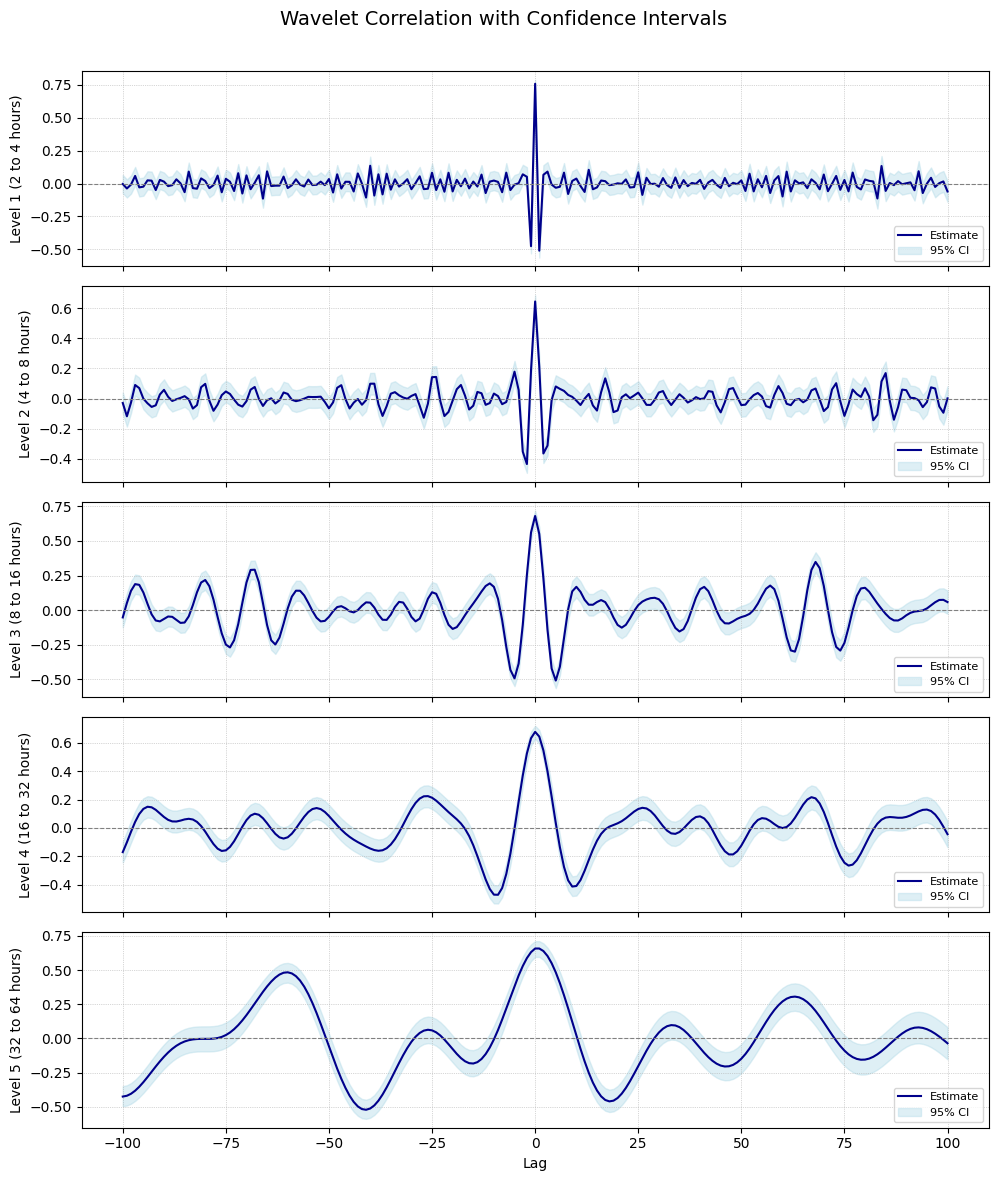

In [13]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 12)) 

for level in range(5):
    lower = []
    estimate = []
    upper = []
    for lag in lags:
        lb, est, ub = wavelet_correlation_CI(btc_logr, sol_logr, "db6", level+1, lag, 0.05)
        lower.append(lb)
        estimate.append(est)
        upper.append(ub)
    
    ax[level].plot(lags, estimate, color='darkblue', label="Estimate")
    ax[level].fill_between(lags, lower, upper, color='lightblue', alpha=0.4, label="95% CI")
    ax[level].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax[level].set_ylabel(f"Level {level+1} ({2**(level+1)} to {2**(level+2)} hours)")
    ax[level].legend(loc="lower right", fontsize=8)
    ax[level].grid(True, linestyle=':', linewidth=0.5)

ax[-1].set_xlabel("Lag")
plt.suptitle("Wavelet Correlation with Confidence Intervals", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()